## 프로젝트: 고양이 수염 스티커 만들기

### 루브릭

|평가문항 |상세기준 |
|---|---|
|1. 자기만의 카메라앱 기능 구현을 완수하였다. |얼굴 영역과 랜드마크를 정확하게 검출하고, 스티커 사진을 합성시키는 데 성공하였다. |
|2. 스티커 이미지를 정확한 원본 위치에 반영하였다.	|정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다. |
|3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.	|얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.|


In [1]:
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리

import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


### Step 1. 스티커 구하기 or 만들기

#### flaticon 사이트에 공개되어 있는 고양이 수염 이미지를 다운로드
고양이 수염 이미지를 flaticon 사이트에서 다운로드 받아 `~/aiffel/CV_sticker/sticker`경로에 업로드했다.

In [2]:
# 업로드된 이미지 확인
!tree ~/aiffel/CV_sticker/sticker

/aiffel/aiffel/CV_sticker/sticker
├── cat-whiskers_mouth.png
└── cat-whiskers.png

0 directories, 2 files


#### 셀카 이미지 업로드
local 에서 aiffel cloud 로 `~/aiffel/CV_sticker/images`경로에 업로드했다.

In [3]:
# 업로드된 이미지 확인
!tree ~/aiffel/CV_sticker/images

/aiffel/aiffel/CV_sticker/images
├── down.png
├── far.png
├── image.png
├── left.png
├── right.png
├── tilt.png
└── up.png

0 directories, 7 files


### Step 2. 얼굴 검출 & 랜드마크 검출 하기
오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

dlib 의 shape predictor 를 사용하기 위해서 모델을 다운받고 압축을 해제한다.

In [4]:
!mkdir -p ~/aiffel/CV_sticker/models
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/CV_sticker/models
!cd ~/aiffel/CV_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

--2024-06-04 07:59:03--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  70.6MB/s    in 0.9s    

2024-06-04 07:59:04 (70.6 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file ./models/shape_predictor_68_face_landmarks.dat already exists.


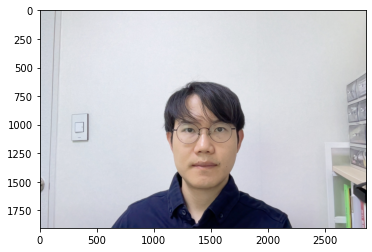

In [5]:
# 준비한 셀카 이미지 읽기

my_image_path = 'images/image.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다 -> channel의 순서: BGR
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # dlib 에서 사용하기 위해서 channel 의 순서를 변경(BGR2RGB)하여 보관해둔다.
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

plt.imshow(img_rgb) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

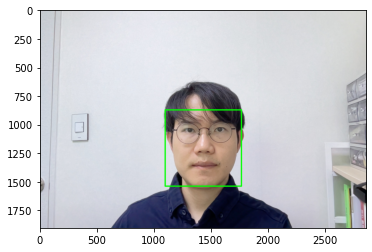

In [6]:
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기 객체를 생성
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, 
                  lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 img_show 위에 직각 사각형을 그림

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))  # 채널 순서 변환후 출력
plt.show()

In [7]:
model_path = '{}/aiffel/CV_sticker/models/shape_predictor_68_face_landmarks.dat'.format(os.getenv('HOME'))
# 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)
# dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
# landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
# dlib.rectangle: 내부를 예측하는 박스
# dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄


In [8]:
list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성    

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

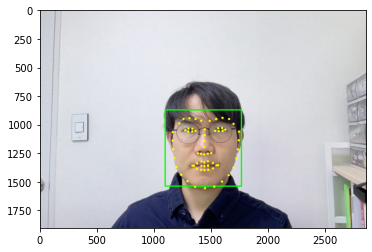

In [9]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 10, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

### Step 3. 스티커 적용 위치 확인하기

고양이 수염이 적용 될 위치를 landmark를 사용해서 계산해 주세요.

코 끝인 33 번보다 좋은 위치가 있을 거예요.

![](E-8-8.png)

코의 끝부분 (33) 이 아닌 코의 중간 부분 (30)을 기준점으로 사용하기로 했다.

In [10]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(345, 98) (531, 284)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
# → [[(368, 153), (368, 174), (371, 195), (376, 215), (382, 235), (391, 252), (404, 266), (420, 277), (441, 279), (461, 276), (480, 266), (495, 252), (508, 235), (516, 216), (520, 195), (523, 173), (524, 151), (377, 131), (386, 119), (399, 116), (413, 118), (425, 124), (454, 121), (466, 114), (481, 112), (494, 114), (503, 127), (439, 143), (438, 156), (438, 169), (437, 182), (423, 197), (431, 199), (438, 200), (446, 199), (454, 197), (391, 147), (399, 142), (409, 143), (416, 149), (408, 150), (399, 150), (464, 147), (472, 141), (482, 141), (489, 145), (482, 149), (473, 149), (411, 227), (421, 222), (432, 218), (439, 220), (446, 218), (458, 222), (471, 227), (458, 234), (446, 238), (438, 238), (431, 238), (420, 235), (415, 227), (432, 227), (439, 228), (447, 227), (466, 227), (446, 228), (438, 229), (431, 228)]]

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[33], landmark[51]) # 코의 index는 30 입니다
#     x = round((landmark[33][0] + landmark[51][0])/2) # 이미지에서 코 부위의 x값
#     y = round((landmark[33][1] + landmark[51][1])/2) # 이미지에서 코 부위의 y값
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] # 이미지에서 코 부위의 y값
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(1434, 1261) (1435, 1332)
(x,y) : (1434,1197)
(w,h) : (667,667)


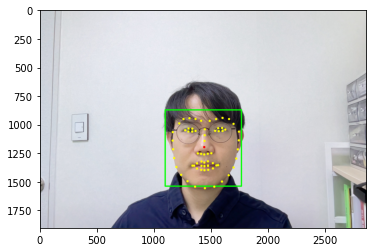

In [11]:
cv2.circle(img_show, (x,y), 10, (0, 0, 255), -1)
# cv2.circle: OpenCV의 원을 그리는 함수
# img_show 이미지 위 각각의 point에
# 크기가 10이고 BGR:(0, 255, 255) = 노란색으로 내부가 채워진(-1) 원을 그림
# (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

# RGB 이미지로 전환
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) 
plt.imshow(img_show_rgb) # 이미지를 준비
plt.show() # 이미지를 출력

#### 스티커 불러와서 적용 위치에 알맞게 기준 위치 조정 및 crop 하기

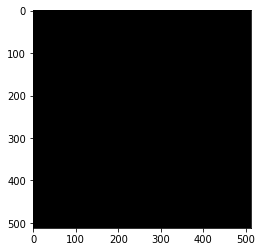

In [12]:
# 스티커 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/CV_sticker/sticker/cat-whiskers.png' # 고양이 수염 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

imread 로 출력하는 경우, 배경색이 검게 나와 안보일 수 있다. 아래는 배경색이 흰색인 경우이다.
![](./sticker/cat-whiskers.png)

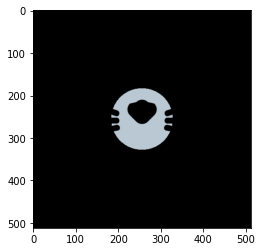

In [13]:
# 스티커 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/CV_sticker/sticker/cat-whiskers_mouth.png' # 고양이 수염 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

imread 로 출력하는 경우, 배경색이 검게 나와 안보일 수 있다. 아래는 배경색이 흰색인 경우이다.
![](./sticker/cat-whiskers_mouth.png)

In [14]:
sticker_path = os.getenv('HOME')+'/aiffel/CV_sticker/sticker/cat-whiskers_mouth.png' # 고양이 수염 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 크기 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수
    # cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 스티커 이미지의 차원 확인

(667, 667, 3)


##### 배운것

alpha 값은 투명도를 의미한다. 0(완전 투명) ~ 255(완전 불투명)으로 값이 커진다.
imshow에선 알파채널의 투명도 값이 적용되지 않은 상태로 보여주므로 배경 색이 검다.
(ref: https://notou10.github.io/opencv/2021/01/26/opencv_alphachannel.html)

In [16]:
(img_sticker == 0).any(2).astype(np.int8).shape
# img_sticker = cv2.imread(sticker_path, -1) 
# img_sticker[:,:,3].shape

(667, 667)

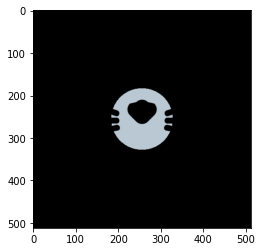

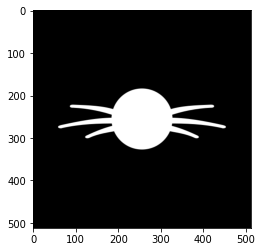

In [17]:
sticker_path = os.getenv('HOME')+'/aiffel/CV_sticker/sticker/cat-whiskers_mouth.png' # 고양이 수염 이미지의 경로
img_sticker = cv2.imread(sticker_path, -1) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환

plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_sticker[:,:,3], cv2.COLOR_BGR2RGB))
plt.show()

sticker 이미지와 원본 이미지를 합칠 때, sticker 이미지 행열의 값이 0 인 부분을 배경으로 가정하고, 해당 부분은 원본 이미지의 픽셀을, 그렇지 않은 부분은 sticker 이미지의 픽셀값을 가져오도록 되어있었다. 그런데, 고양이 수염의 색이 검은색인 경우, foreground 부분도 배경으로 잘못 인식이 되었다.
해결안: cv2.imread로 불러올 때, 옵션을 Unchnaged (-1) 로 설정하면, alpha 를 불러올 수 있다. 이 alpha 투명도 값이며 png 파일의 투명 배경을 0으로 구분해주는 channel 임을 알게되어 이 정보를 두 이미지를 합치는데 사용했다.

In [18]:
# x,y,w,h 모두 위에서 반복문 안에서 지정해준 값임
# x는 이미지에서 코 부위의 x값
# y는 이미지에서 코 부위의 y값
# w는 얼굴 영역의 가로를 차지하는 픽셀의 수
# h는 얼굴 영역의 가로를 차지하는 픽셀의 수
refined_x = x - img_sticker.shape[0]//2# 437 - (187//2) = 437-93 = 344
refined_y = y - img_sticker.shape[1]//2 # 89-187 = -98
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
# 즉, refined_x, refined_y값에서 왕관 이미지가 시작됨
print (f'original (x,y) : ({refined_x},{refined_y})') # 음수 발생 : 이미지 범위를 벗어남
# 우리는 현재 이마 자리에 왕관을 두고 싶은건데, 이마위치 - 왕관 높이를 했더니 이미지의 범위를 초과하여 음수가 나오는 것
# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.

# 왕관 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# 현재 상황에서는 -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 아래와 같은 형식으로 나옵니다.
# 음수값 만큼 왕관 이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    refined_y = 0

print (f'refined (x,y) : ({refined_x},{refined_y})')

original (x,y) : (1178,941)
refined (x,y) : (1178,941)


In [19]:
def get_sticker_area(img_original, img_sticker, refined_x, refined_y, ):

    # sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
    # 예제에서는 (344,0) 부터 (344+187, 0+89) 범위의 이미지를 의미합니다.
    # 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
    # img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    # img_show[0:0+89, 344:344+187]
    # img_show[0:89, 344:531]
    # 즉, x좌표는 344~531 / y좌표는 0~89가 됨
    sticker_area = img_original[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    # 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
    # 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
    # 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
    # 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
    # sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
    # 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
    # 나머지 부분은 스티커로 채워주면 됨
    # np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
    # 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
    # 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
    return sticker_area

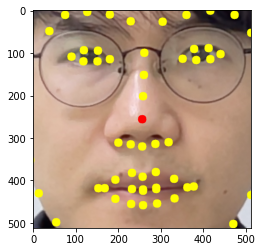

In [20]:
sticker_area = get_sticker_area(img_show, img_sticker, refined_x, refined_y)
plt.imshow(cv2.cvtColor(sticker_area, cv2.COLOR_BGR2RGB))
plt.show()

### Step 4. 스티커 적용하기

(1) 오늘 배운 np.where 를 사용해서 스티커를 적용해 주세요.

In [21]:
def attach_sticker(img_show, x, y, sticker_area, img_sticker ):
    img_ = img_show.copy()
    img_[y:y+img_sticker.shape[0], 
             x:x+img_sticker.shape[1]] = \
        np.where(np.expand_dims(img_sticker[:,:,3]==0,axis=-1),
                 sticker_area,
                 img_sticker[:,:,:3]).astype(np.uint8)
    
    return img_

sticker_attached_img_show = attach_sticker(img_show, refined_x, refined_y, sticker_area, img_sticker )

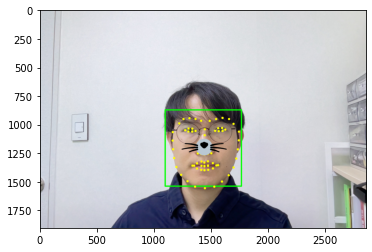

In [24]:

# 왕관 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 왕관 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(sticker_attached_img_show, cv2.COLOR_BGR2RGB))
plt.show()

(2) 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다. opencv 의 cv2.addWeighted() 를 참고하세요.

In [25]:
def attach_sticker(img_show, x, y, sticker_area, img_sticker, alpha = 0.8 ):
    src2 = img_show.copy()
    src1 = img_show
    beta = 1 - alpha
    
    src2[y:y+img_sticker.shape[0], 
             x:x+img_sticker.shape[1]] = \
        np.where(np.expand_dims(img_sticker[:,:,3]==0,axis=-1),
                 sticker_area,
                 img_sticker[:,:,:3]).astype(np.uint8)
    
    return cv2.addWeighted( src1, alpha, src2, beta, gamma=0.0)

sticker_attached_img_show = attach_sticker(img_show, refined_x, refined_y, sticker_area, img_sticker )

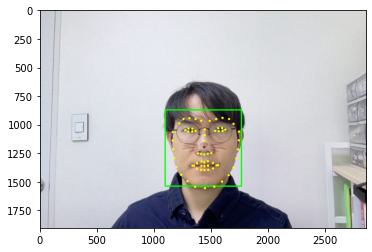

In [26]:
plt.imshow(cv2.cvtColor(sticker_attached_img_show, cv2.COLOR_BGR2RGB))
plt.show()

### Step 5. 문제점 찾아보기

1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

#### 파이프라인 함수로 만들기
윗 부분에서 구현한 각 기능을 모듈화하여 사용하기 위해서 각 부분을 함수로 구현했다.

In [27]:
def add_rects(img_show, dlib_rects):
    """
        주어진 img_show 이미지에 dlib_rects 안의 rectangle을 표시한다.
    """
    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽
        
        # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA) 

def add_landmarks(img_show, list_landmarks):
    # list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 10, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

        
def find_landmarks(
    img_rgb, dlib_rects,
    model_path = '{}/aiffel/CV_sticker/models/shape_predictor_68_face_landmarks.dat'.format(os.getenv('HOME')),
    ):
    """
        주어진 이미지 img_rgb 와 얼굴영역 리스트 dlib_rects 에 대해서, 
        각 얼굴 영역에서 랜드마크를 찾아 찾아진 얼굴영역 갯수 만큼의 item을 
        가진 리스트 형태로 반환한다. 
    """
    landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # return
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄
    
    list_landmarks = []    # 랜드마크의 위치를 저장할 list 생성 

    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    # face landmark 좌표를 저장해둡니다
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
        list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장
    
    return list_landmarks

def find_center_point(dlib_rects, list_landmarks,
                    verbose=False):
    """
    
    """
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
        x = landmark[30][0] # 이미지에서 코 부위의 x값
        y = landmark[30][1] # 이미지에서 코 부위의 y값
        w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)

    if verbose:
        print('Rectangle')
        print (f'(x,y) : ({x},{y}), (w,h) : ({w},{h})')

    return x, y, w, h

def crop_sticker(img_sticker, center_xy, verbose=False):
    """
        
    """

    # x는 이미지에서 코 부위의 x값
    # y는 이미지에서 코 부위의 y값
    # w는 얼굴 영역의 가로를 차지하는 픽셀의 수
    # h는 얼굴 영역의 가로를 차지하는 픽셀의 수
    x, y = center_xy
    refined_x = x - img_sticker.shape[0]//2 # 437 - (187//2) = 437-93 = 344
    refined_y = y - img_sticker.shape[1]//2 # 89-187 = -98
    # 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
    # 즉, refined_x, refined_y값에서 왕관 이미지가 시작됨
    if verbose:  print (f'original (x,y) : ({refined_x},{refined_y})') # 음수 발생 : 이미지 범위를 벗어남
    # 우리는 현재 이마 자리에 왕관을 두고 싶은건데, 이마위치 - 왕관 높이를 했더니 이미지의 범위를 초과하여 음수가 나오는 것
    # opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.

    # 왕관 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함
    # 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
    # 현재 상황에서는 -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 아래와 같은 형식으로 나옵니다.

    # 음수값 만큼 스티커 이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0  # refined_x를 sticker_img, 원본 img 상의 동일한 위치를 가리키도록
        
    # 스티커 이미지를 씌우기 위해 스티커 이미지가 시작할 y좌표 값 조정
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :] 
        # refined_y가 음수 index 이면, 그에 해당하는 index 크기 만큼의 사이즈가 cropped out 된다. 
        refined_y = 0 # refined_y를 sticker_img, 원본 img 상의 동일한 위치를 가리키도록

    if verbose: print (f'refined (x,y) : ({refined_x},{refined_y})')
    
    return img_sticker, (refined_x, refined_y)


def merge_sticker(img_show, sticker_xy, img_sticker, 
                   alpha = 0.5 ):
    src1 = img_show
    src2 = img_show.copy()
    x, y = sticker_xy
    
    beta = 1 - alpha
    
    w, h = img_sticker.shape[1], img_sticker.shape[0],
    
    sticker_area = src1[y:y+h, x:x+w]
    cropped_w, cropped_h = sticker_area.shape[1], sticker_area.shape[0]
    bool_arr = np.expand_dims(img_sticker[:cropped_h,:cropped_w,3]==0, axis=-1)
    
    src2[y:y+h, x:x+w] = np.where(bool_arr, sticker_area, img_sticker[:cropped_h,:cropped_w,:3]).astype(np.uint8)
    
    return cv2.addWeighted( src1, alpha, src2, beta, gamma=0.0)



def attach_sticker(my_image, sticker_path, 
                   debug=False, title=''):
    if isinstance(my_image, str):
        img_bgr = cv2.imread(my_image)    # OpenCV로 이미지를 불러옵니다
    elif isinstance(my_image, np.ndarray):
        img_bgr = my_image.copy()    # np.ndarray 가 input 으로 들어오면 복사해서 사용합니다.
    else:
        raise NotImplimentedError  # 앞서 명시된 두 타입이 아니면 에러를 발생하게 합니다.
        
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
    
    detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
    dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
    if debug: add_rects(img_show, dlib_rects)
    
    list_landmarks = find_landmarks(img_rgb, dlib_rects,)
    if debug: add_landmarks(img_show, list_landmarks)
    
    if len(dlib_rects) > 0:

        x, y, w, h = find_center_point(dlib_rects, list_landmarks, verbose=debug)
        if debug: cv2.circle(img_show, (x,y), 10, (0, 0, 255), -1)


        img_sticker = cv2.imread(sticker_path, -1) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
        img_sticker, refined_xy = crop_sticker(img_sticker, center_xy=(x, y))

        img_show = merge_sticker(
            img_show, refined_xy, img_sticker)
    
    else:
        print('Face is not found')

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

- debug mode

Rectangle
(x,y) : (1434,1197), (w,h) : (667,667)


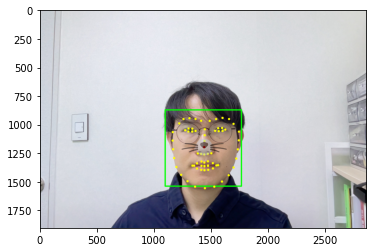

In [28]:
attach_sticker(my_image='images/image.png',
               sticker_path='sticker/cat-whiskers_mouth.png',
               debug=True)

debug 모드를 통해서는 인식된 얼굴 영역의 위치와 크기를 알 수 있다.
출력된 그림을 보면, **얼굴 영역과 랜드마크가 정확하게 검출되고, 스티커 사진도 적절한 위치에 합성시키는데 성공하였다.**

- normal mode

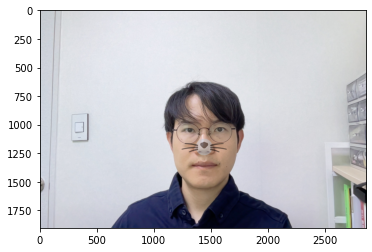

In [29]:
attach_sticker(my_image='images/image.png',
               sticker_path='sticker/cat-whiskers_mouth.png',
               debug=False)

debug 모드를 해제하면 랜드마크와 얼굴영역이 표시되지 않고, 에러나 시스템 메시지가 보이지 않는다.

#### 1. 얼굴 방향 및 각도에 따른 동작

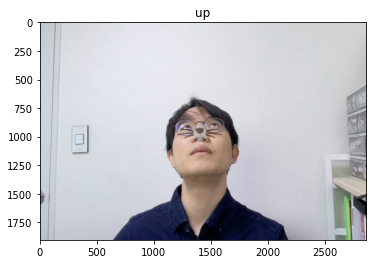

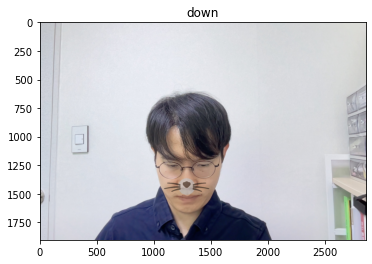

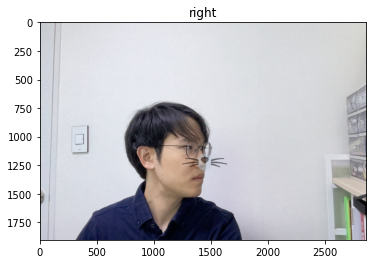

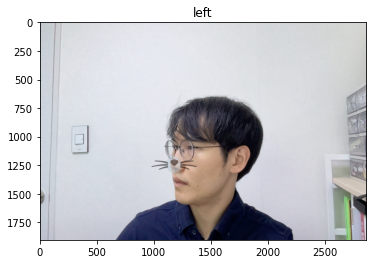

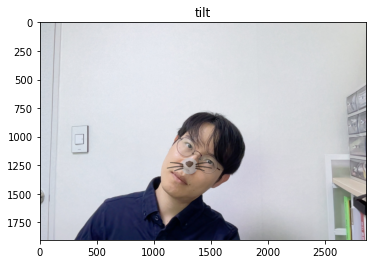

CPU times: user 29.7 s, sys: 1.08 s, total: 30.8 s
Wall time: 30.4 s


In [30]:
%%time
file_names = ('up', 'down', 'right', 'left', 'tilt')
for name in file_names:
    attach_sticker(my_image=f'images/{name}.png',
               sticker_path='sticker/cat-whiskers_mouth.png',
                title=name,)
    

#### 밝기 및 명암에 따른 동작

openCV 에 `convertScaleAbs` 라는 함수가 있어서 이를 이용해서 명암(alpha)과 밝기(beta)를 조절하며 얼굴인식 동작을 관찰했다.

Face is not found


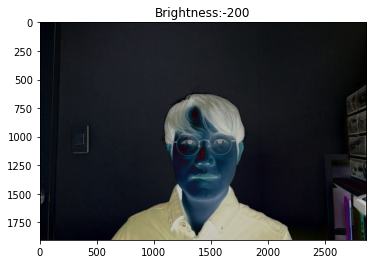

Rectangle
(x,y) : (1416,1206), (w,h) : (667,667)


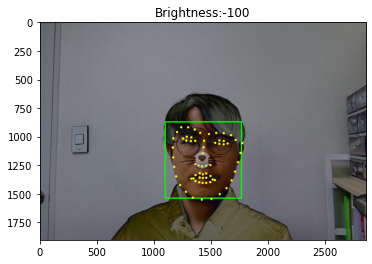

Rectangle
(x,y) : (1434,1197), (w,h) : (667,667)


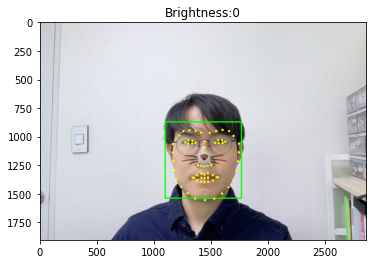

Rectangle
(x,y) : (1437,1196), (w,h) : (667,667)


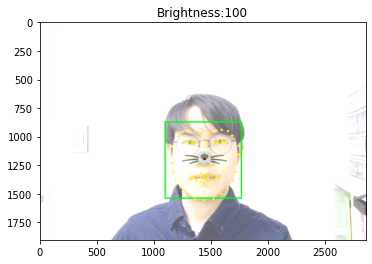

Face is not found


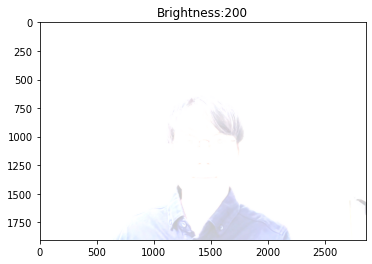

CPU times: user 29.8 s, sys: 837 ms, total: 30.6 s
Wall time: 30.3 s


In [31]:
%%time
# 밝기 변화에 따른 동작 관찰
for i, beta in enumerate((-200, -100, 0, 100, 200)):
    image = cv2.imread('images/image.png')
    my_image = cv2.convertScaleAbs(image, alpha=1, beta=beta)
    attach_sticker(my_image=my_image,
                   sticker_path='sticker/cat-whiskers_mouth.png',
                   title=f'Brightness:{beta}',
                   debug=True)

Face is not found


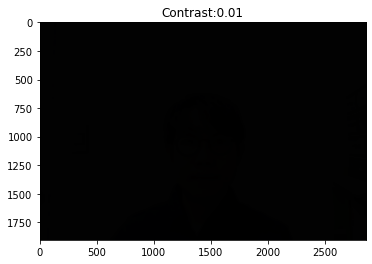

Rectangle
(x,y) : (1428,1193), (w,h) : (667,667)


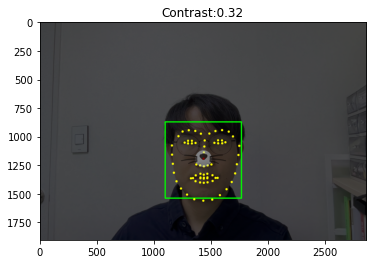

Rectangle
(x,y) : (1434,1197), (w,h) : (667,667)


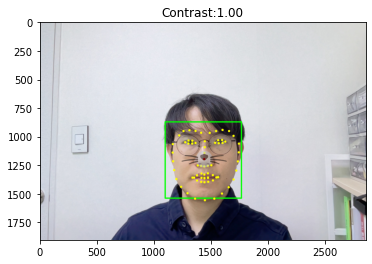

Rectangle
(x,y) : (1426,1209), (w,h) : (667,667)


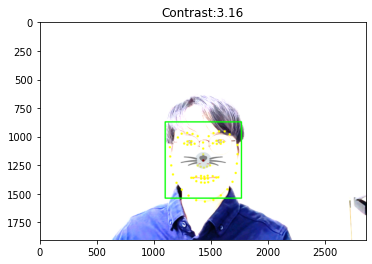

Face is not found


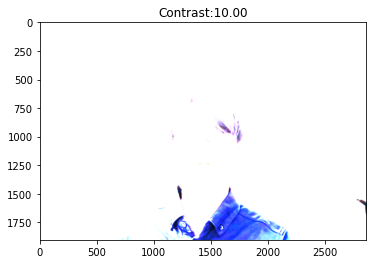

CPU times: user 29.6 s, sys: 656 ms, total: 30.2 s
Wall time: 29.9 s


In [32]:
%%time
# 명암 변화에 따른 동작 관찰
for alpha in (10**-2, 10**-0.5, 10**0, 10**0.5, 10**1):
    image = cv2.imread('images/image.png')
    my_image = cv2.convertScaleAbs(image, alpha=alpha, beta=0)
    attach_sticker(my_image=my_image,
                   sticker_path='sticker/cat-whiskers_mouth.png',
                   title=f'Contrast:{alpha:.2f}',
                   debug=True)

#### 셀카 이미지의 회전, 반전 변환에 대한 동작

Rectangle
(x,y) : (1590,1143), (w,h) : (667,667)


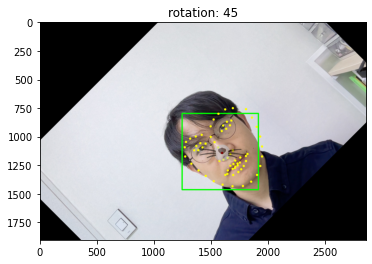

Rectangle
(x,y) : (1606,1128), (w,h) : (667,667)


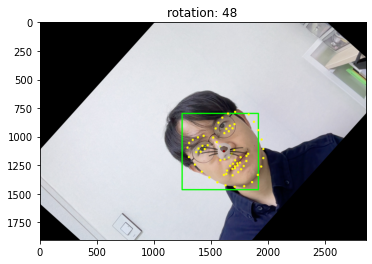

Face is not found


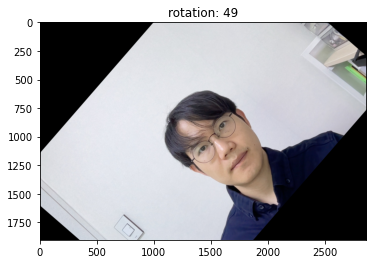

Face is not found


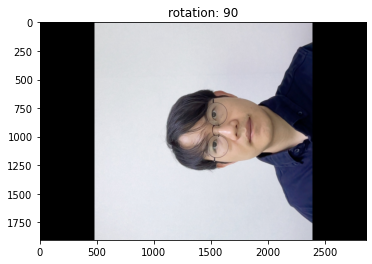

Face is not found


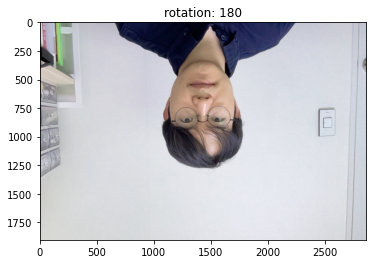

CPU times: user 30 s, sys: 849 ms, total: 30.8 s
Wall time: 30.5 s


In [34]:
%%time
for degree in (45, 48, 49, 90, 180):
    img = cv2.imread('images/image.png')  # 셀카 이미지 불려오기
    rows,cols, _ = img.shape  # row, column 정보 보관
    # cols-1 and rows-1 are the coordinate limits.
    M = cv2.getRotationMatrix2D( ((cols-1)/2.0, (rows-1)/2.0),degree,1)

    my_image = cv2.warpAffine(img,M,(cols,rows))

    attach_sticker(my_image=my_image,
                   sticker_path='sticker/cat-whiskers_mouth.png',
                   title=f'rotation: {degree}',
                   debug=True)

#### 셀카 촬영 거리(사이즈 및 해상도) 변환에 대한 동작

Face is not found


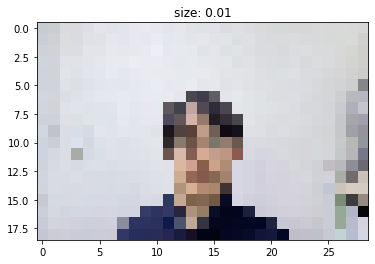

Rectangle
(x,y) : (143,119), (w,h) : (63,63)


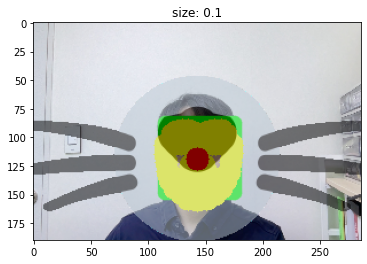

Rectangle
(x,y) : (715,599), (w,h) : (322,322)


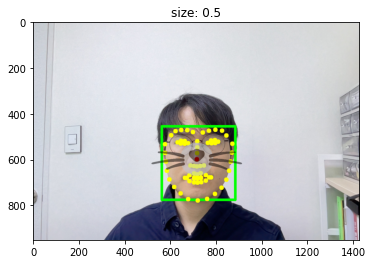

Rectangle
(x,y) : (1434,1197), (w,h) : (667,667)


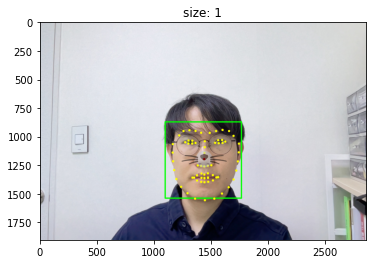

In [35]:
for size in (0.01, 0.1, 0.5, 1):
    img = cv2.imread('images/image.png')
    my_image = cv2.resize(img,None,fx=size, fy=size, interpolation = cv2.INTER_CUBIC)

    attach_sticker(my_image=my_image,
                   sticker_path='sticker/cat-whiskers_mouth.png',
                   title=f'size: {size}',
                   debug=True)
    

2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!


오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.

- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
    - 얼굴을 상하좌우로 회전시에는, 같은 각도로 회전되어야 할 것 같다.
    tilt, rotation, perspective transformation 

- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
    - 얼굴 인식 모델이 너무 과한 각도 변경에 대해서는 학습하지 못했다.

- 실행 속도가 중요할까요?
    - 영상에 실시간으로 적용시키기 위해서는 실행 속도가 매우 중요할 것 같다. 현재의 실행속도는 6개 이미지에 대해서, 36.5 s. 즉, 평균 6초가 걸리는것으로 나온다.
    - 고해상도 이미지 일수록 (읽고, Rect를 찾는데 처리속도가 많이 걸릴 것으로 생각된다.

- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?
    - 정확도가 다른 작업 (자율주행 자동차의 장애물인식, CCTV의 도둑 인식)에 비해서 정확도가 높지는 않아도 될 것 같다.
    - 얼굴 영역 탐지 정확도는 다양한 각도에 대해서 높아야 할것 같다.
    - 스티커를 위치시킬 부분을 정하는데 필요한 랜드마크에 대한 정확도는 특히 높아야 한다.

### 회고

- 배운 점
    - open cv 는 ~를 사용한 상대경로를 인식하지 못한다.
    - image 를 numpy 로 변환했을때, 0차원은 y 방향과 대응되고, 1차원은 x 방향과 대응이 된다. Image array 의 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
    - cv2.imread 의 두번째 Positional argument 를 -1 (Unchnaged)로 설정하면, alpha 를 불러올 수 있으며, alpha 은 전경(1)과 배경(0)을 구분해준다.
- 아쉬운 점
    - 실행속도를 줄이고 싶었으나, 어느 부분이 가장 시간이 많이 걸리는지 찾지 못했다.
- 느낀 점
    - 재미있다.
- 어려웠던 점
    - 원본 이미지에 랜드마크를 표시할 때에 잘 안보여서 뭔가 잘못된건가 했는데, 랜드마크 표시하는 마커의 사이즈를 올렸더니 잘 보였다.
    - sticker 이미지와 원본 이미지를 합칠 때, sticker 이미지 행열의 값이 0 인 부분을 배경으로 가정하고, 해당 부분은 원본 이미지의 픽셀을, 그렇지 않은 부분은 sticker 이미지의 픽셀값을 가져오도록 되어있었다. 그런데, 고양이 수염의 색이 검은색인 경우, foreground 부분도 배경으로 잘못 인식이 되었다.
        - 해결안: cv2.imread로 불러올 때, 옵션을 Unchnaged (-1) 로 설정하면, alpha 를 불러올 수 있다. 이 alpha 값은 전경과 배경을 구분해주는 channel 임을 알게되어 이 정보를 두 이미지를 합치는데 사용했다.
    